In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pyedflib
from scipy.signal import butter, lfilter, cheby1, filtfilt, medfilt
from scipy import signal
from scipy.signal import medfilt, firwin, convolve

# Plotting Raw data

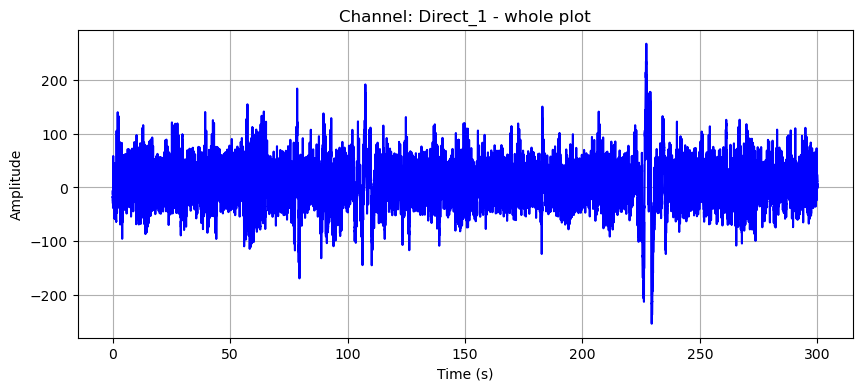

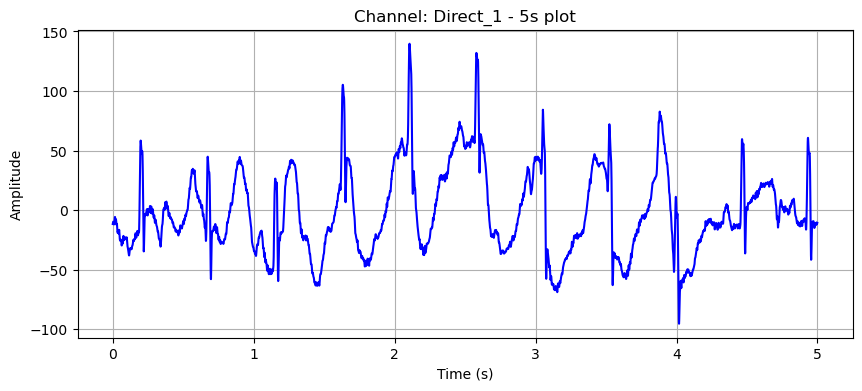

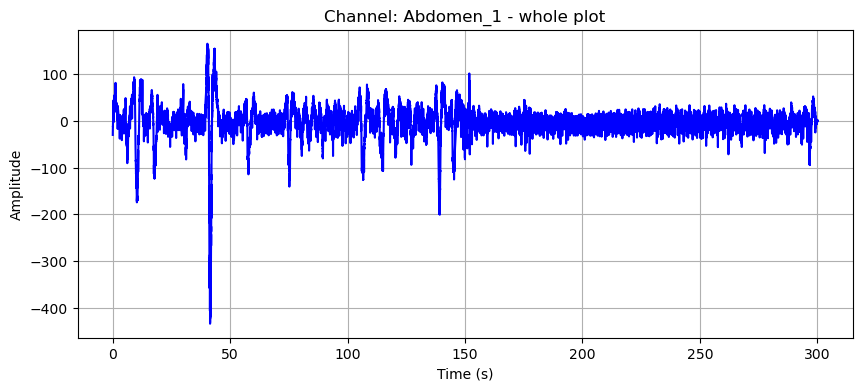

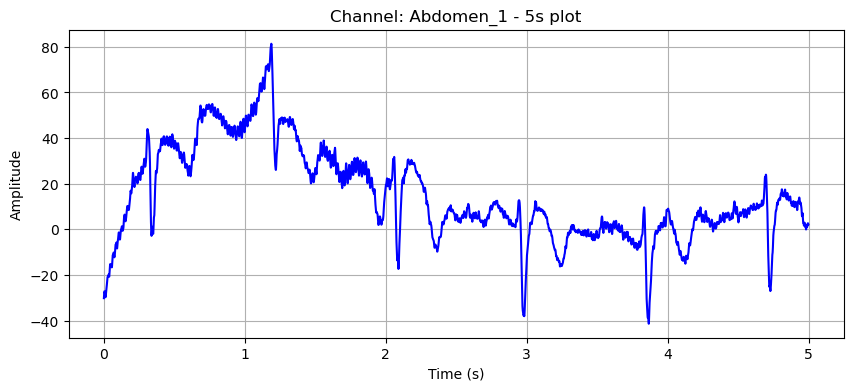

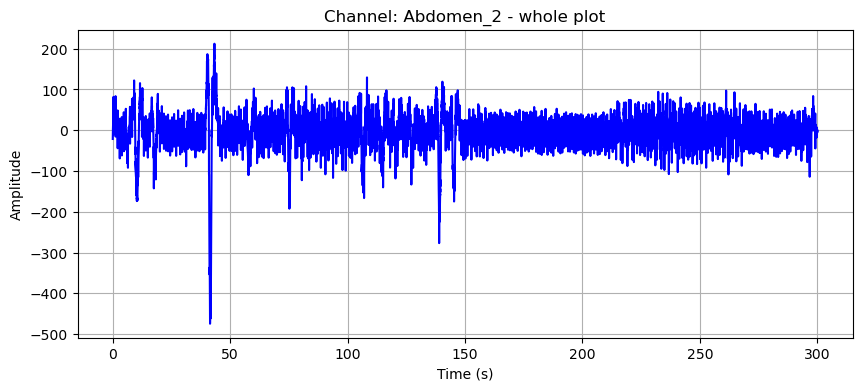

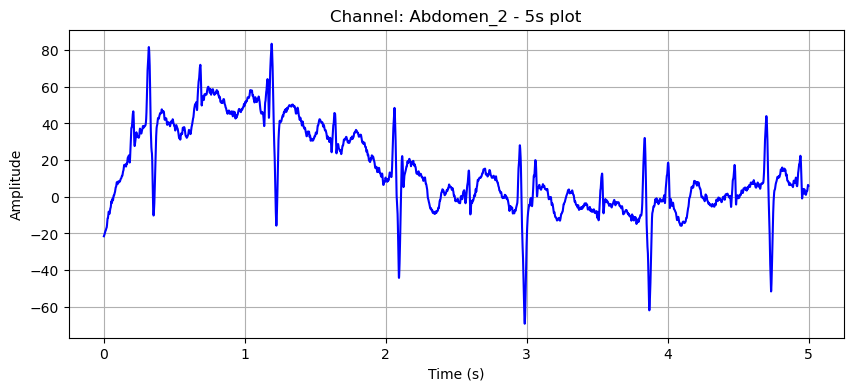

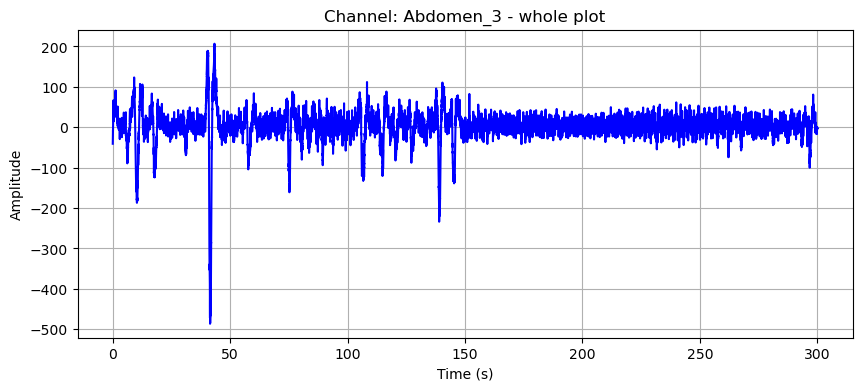

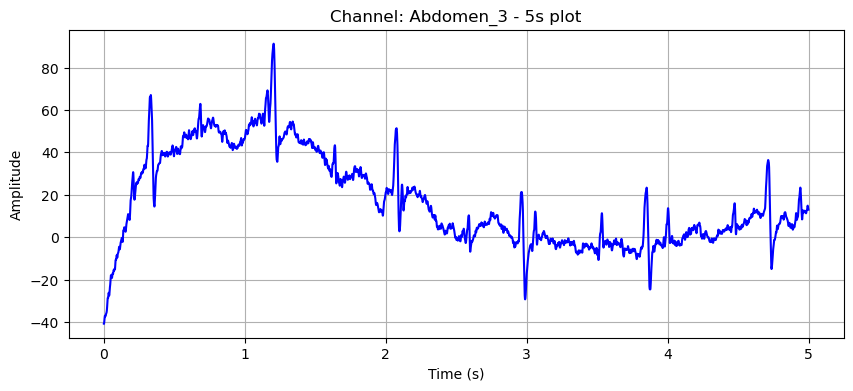

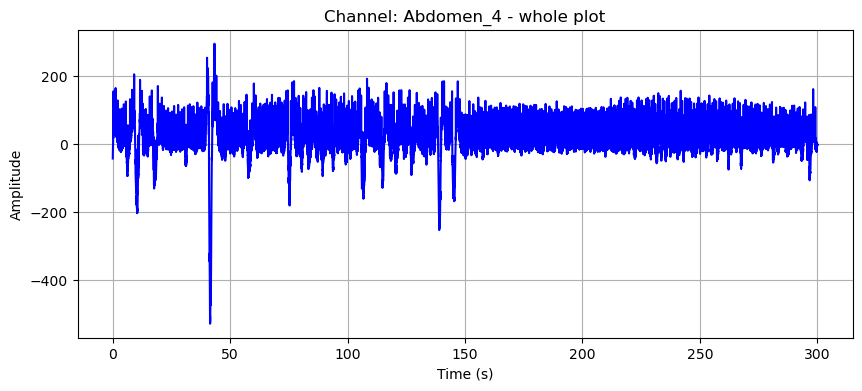

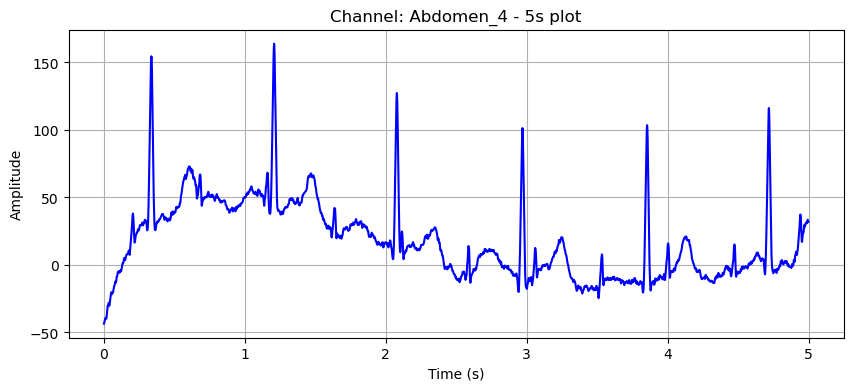

In [2]:
file_path = "/home/ettexham/Desktop/Digital_Signal_Processing/Lab Works/ECG_Data_Filtering/r07.edf"

with pyedflib.EdfReader(file_path) as f:
    # Get the signal labels
    signal_labels = f.getSignalLabels()

    # Iterate over each channel and plot separately
    for i, label in enumerate(signal_labels):
        # Get the signal data for the current channel
        signal_data = f.readSignal(i)

        # Get the sampling frequency for the current channel
        sampling_frequency = f.getSampleFrequency(i)

        # Calculate time array
        time = np.arange(len(signal_data)) / sampling_frequency

        # Plot the current channel
        plt.figure(figsize=(10, 4))
        plt.plot(time, signal_data, color='blue')
        plt.title('Channel: {} - whole plot'.format(label))
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10, 4))
        plt.plot(time[:5000], signal_data[:5000], color='blue')
        plt.title('Channel: {} - 5s plot'.format(label))
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()

# FFT to analyze the frequncy spectrum

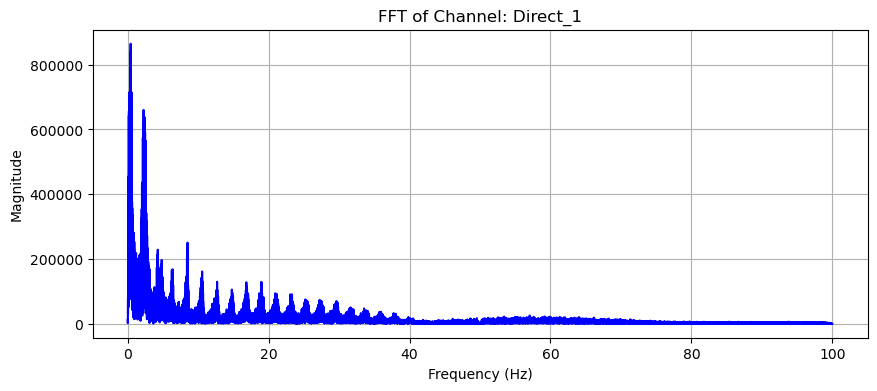

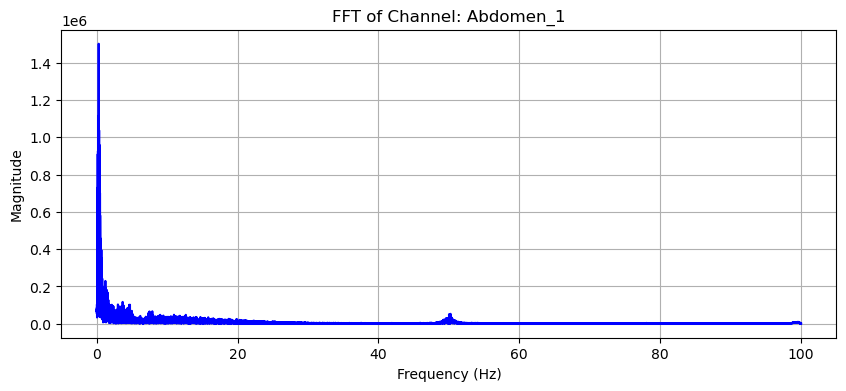

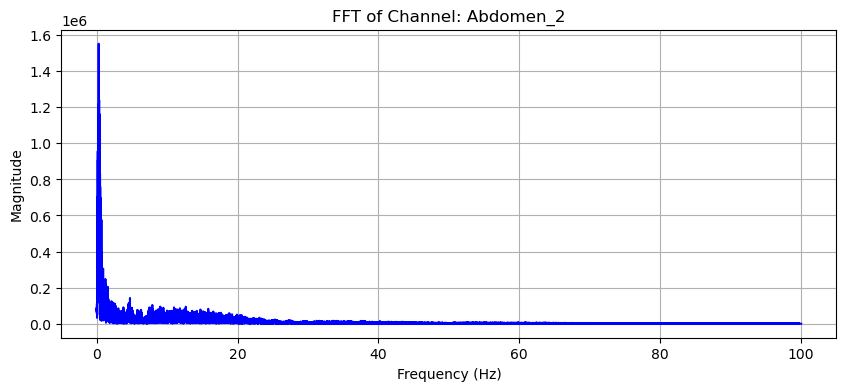

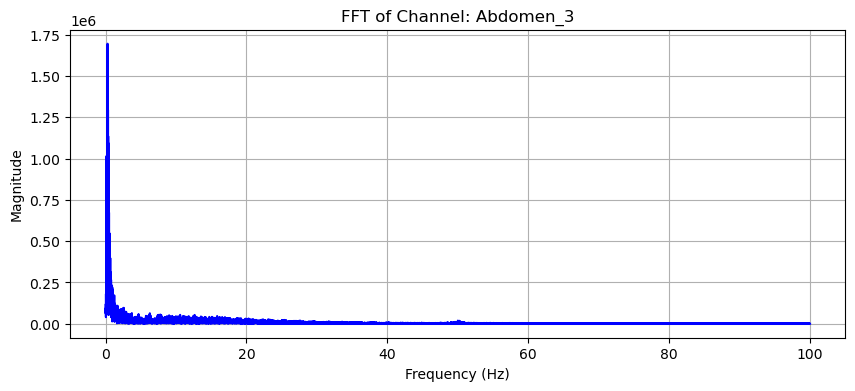

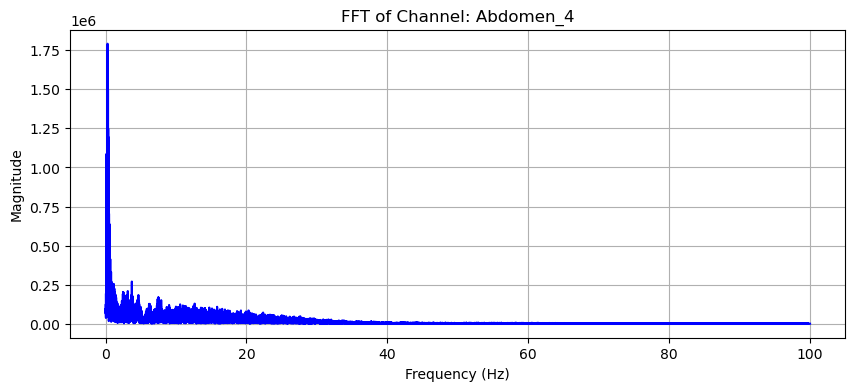

In [3]:
with pyedflib.EdfReader(file_path) as f:
    # Get the signal labels
    signal_labels = f.getSignalLabels()

    # Iterate over each channel and plot and perform FFT
    for i, label in enumerate(signal_labels):
        # Get the signal data for the current channel
        signal_data = f.readSignal(i)

        # Get the sampling frequency for the current channel
        sampling_frequency = f.getSampleFrequency(i)

        # Perform FFT
        fft_freq = np.fft.fftfreq(len(signal_data), 1 / sampling_frequency)
        fft_data = np.abs(np.fft.fft(signal_data))

        # Find the index of the positive frequencies
        positive_freq_index = np.where(fft_freq >= 0)

        # Plot only positive frequencies
        plt.figure(figsize=(10, 4))
        plt.plot(fft_freq[positive_freq_index][:30000], fft_data[positive_freq_index][:30000], color='blue')
        plt.title('FFT of Channel: {}'.format(label))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.show()

## The FFT suggests the cutoff frequency should be around 50Hz.

## Butterworth Lowpass

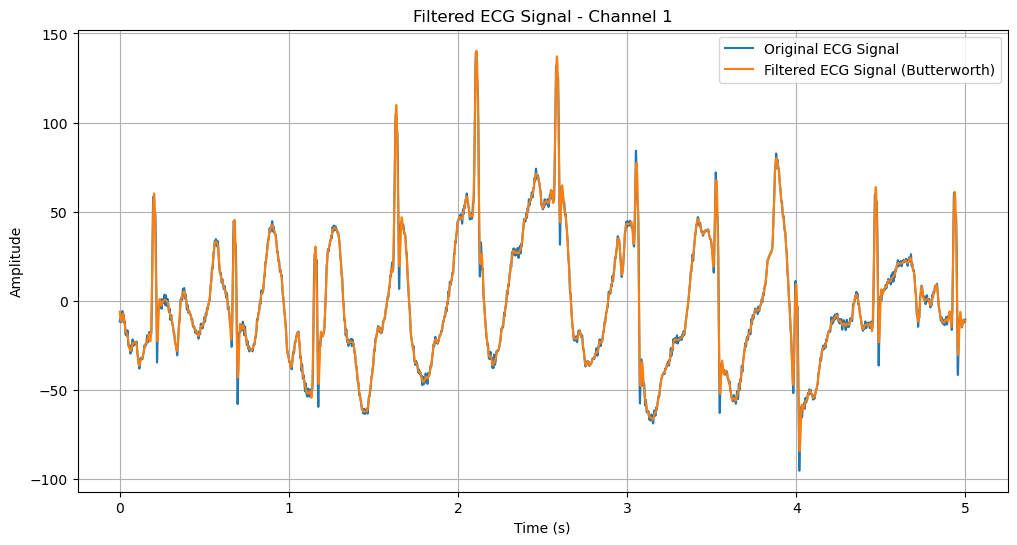

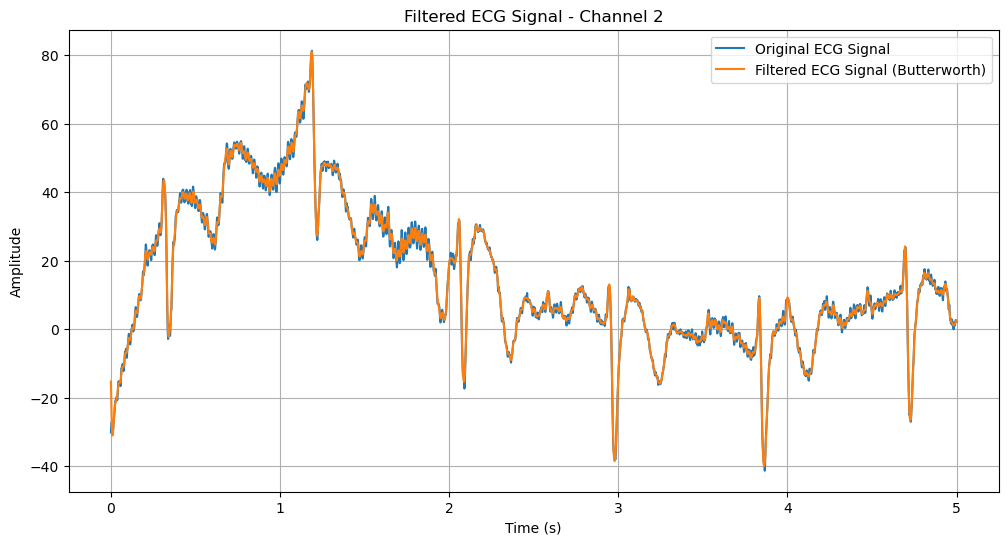

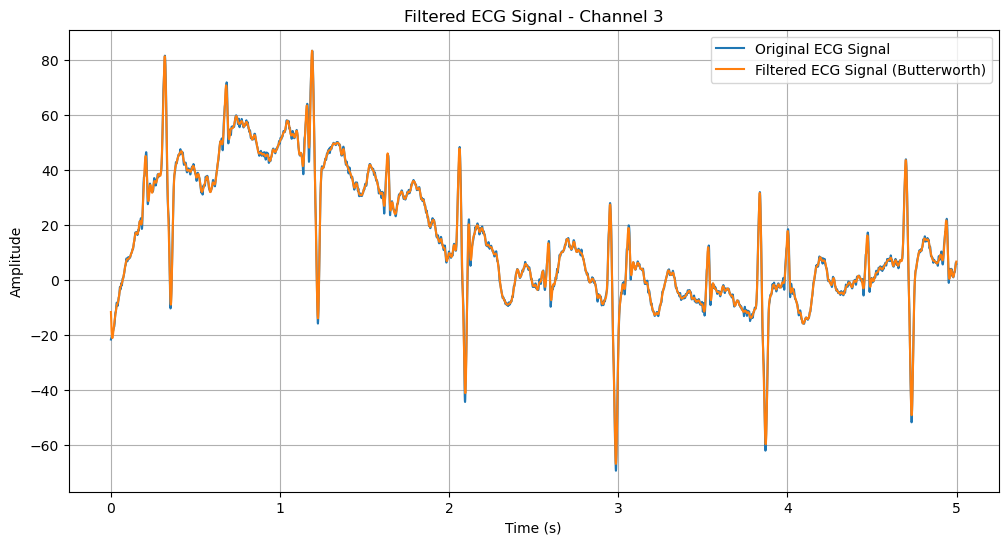

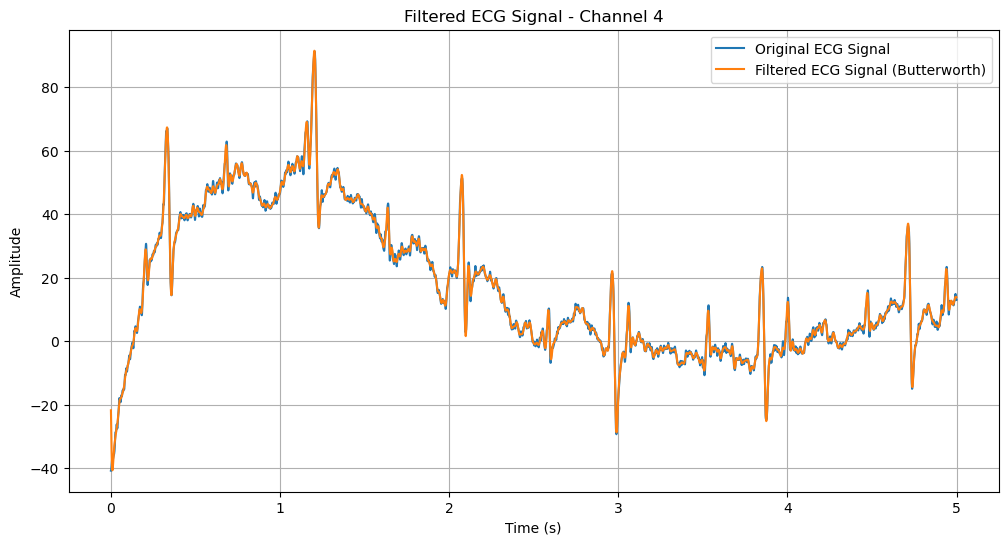

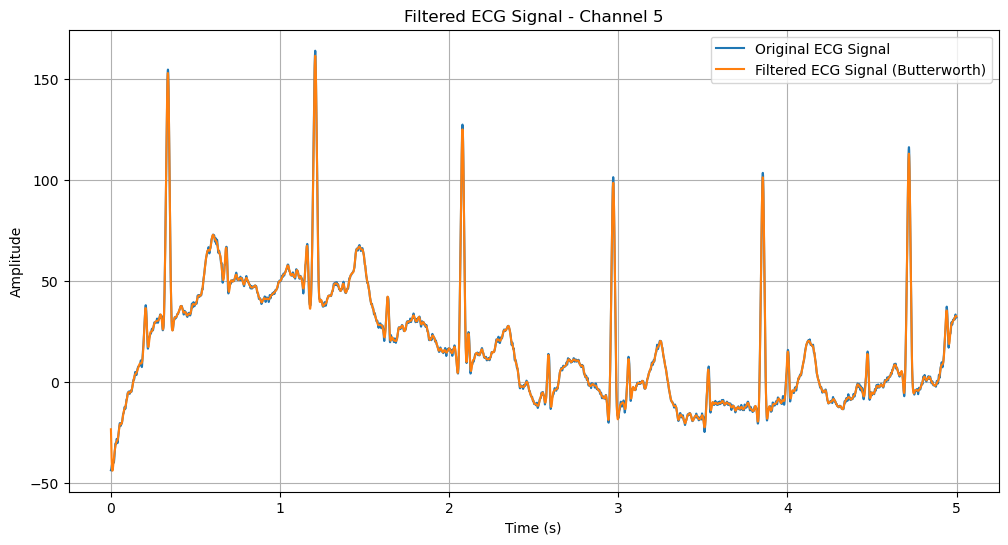

In [4]:
f = pyedflib.EdfReader(file_path)
sample_rate = f.getSampleFrequency(0)
filtered_ecg_signals = []

def butter_lowpass_fir_filter(data, cutoff_freq, fs, numtaps=101):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    taps = firwin(numtaps, normal_cutoff)
    filtered_data = convolve(data, taps, mode='same')
    return filtered_data

cutoff_frequency = 50   
num_taps = 99


for ecg_index in range(len(signal_labels)):
    # Read ECG signal
    ecg_signal = f.readSignal(ecg_index)
    
    filtered_ecg_signal = butter_lowpass_fir_filter(ecg_signal, cutoff_frequency, sample_rate, num_taps)

    # Plot
    t = np.arange(len(ecg_signal)) / sample_rate
    plt.figure(figsize=(12, 6))
    plt.plot(t[:5000], ecg_signal[:5000], label='Original ECG Signal')
    plt.plot(t[:5000], filtered_ecg_signal[:5000], label='Filtered ECG Signal (Butterworth)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Filtered ECG Signal - Channel {ecg_index + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Chebyshev Lowpass

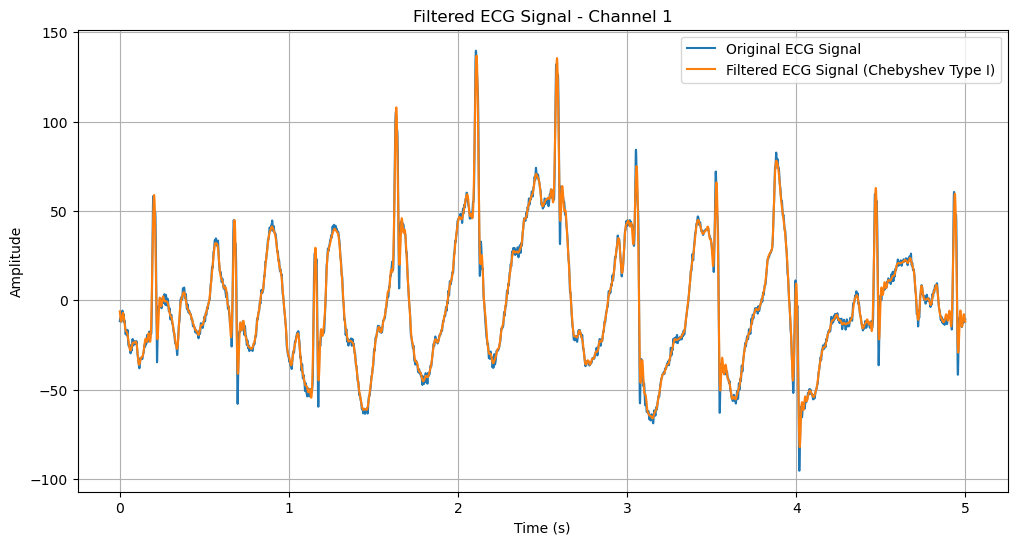

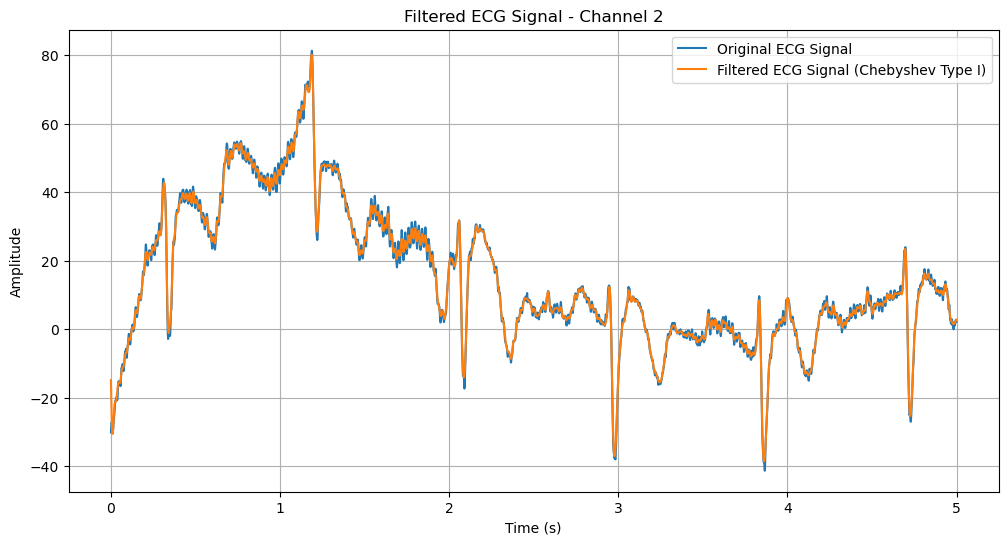

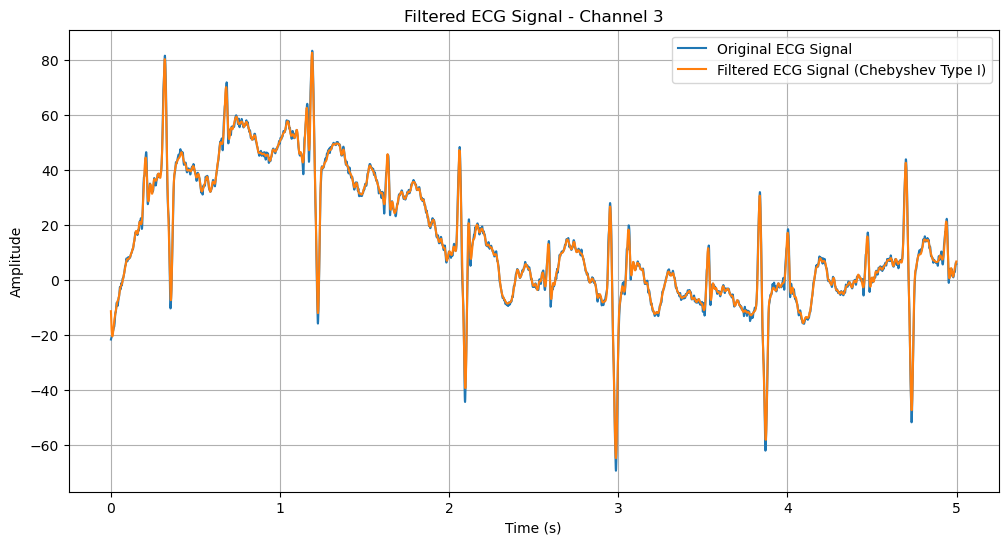

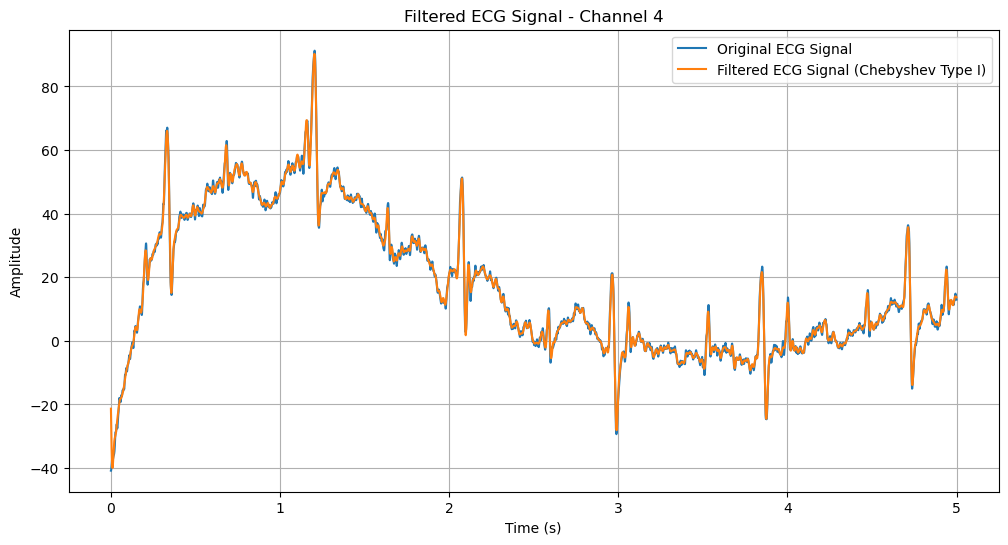

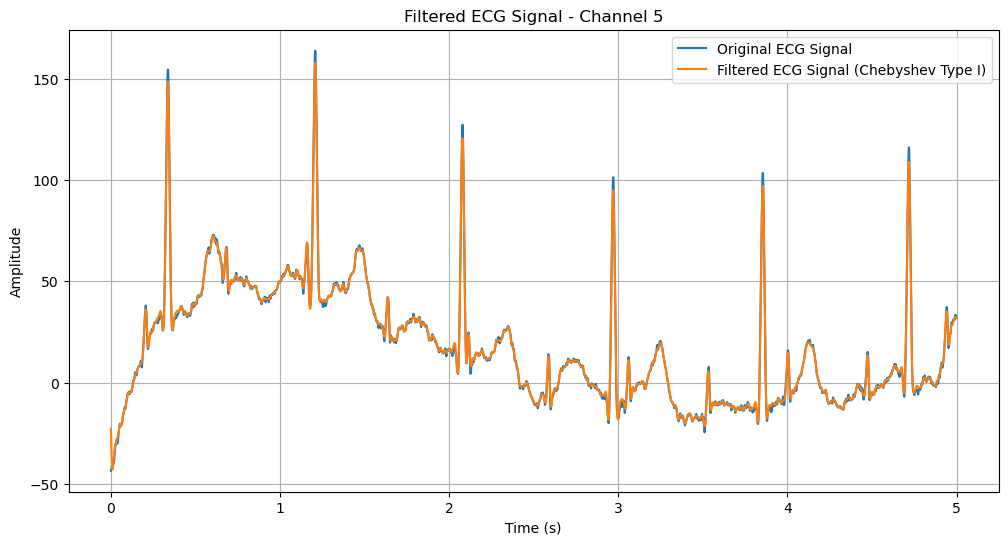

In [6]:
filtered_ecg_signals = []

def chebyshev_lowpass_fir_filter(data, cutoff_freq, fs, numtaps=101, rp=1):
    nyquist_freq = 0.5 * fs
    nyq_cutoff = cutoff_freq / nyquist_freq
    taps = firwin(numtaps, nyq_cutoff, window=('chebwin', rp))
    filtered_data = np.convolve(data, taps, mode='same')
    return filtered_data

cutoff_frequency = 50
num_taps = 101
rp = 1 

for ecg_index in range(len(signal_labels)):
    # Read ECG signal
    ecg_signal = f.readSignal(ecg_index)
    
    filtered_ecg_signal = chebyshev_lowpass_fir_filter(ecg_signal, cutoff_frequency, sample_rate, num_taps, rp)

    # Plot
    t = np.arange(len(ecg_signal)) / sample_rate
    plt.figure(figsize=(12, 6))
    plt.plot(t[:5000], ecg_signal[:5000], label='Original ECG Signal')
    plt.plot(t[:5000], filtered_ecg_signal[:5000], label='Filtered ECG Signal (Chebyshev Type I)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Filtered ECG Signal - Channel {ecg_index + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Median Filter 

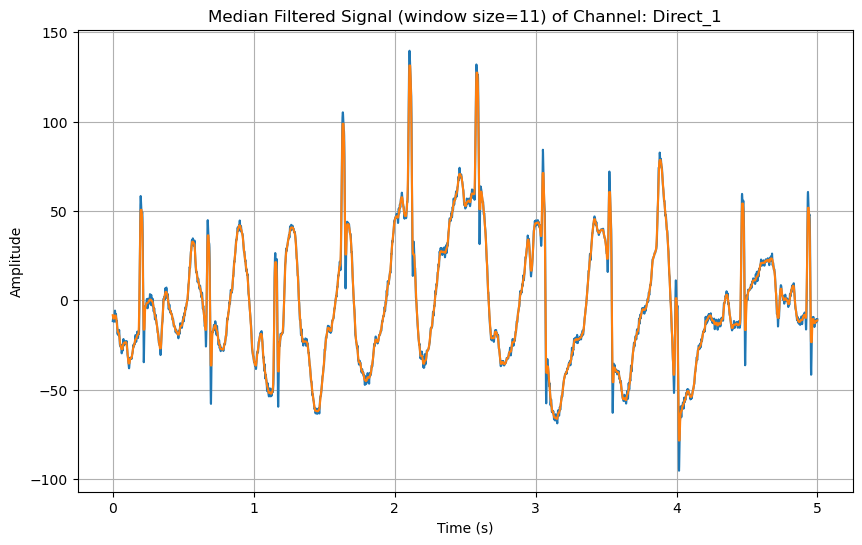

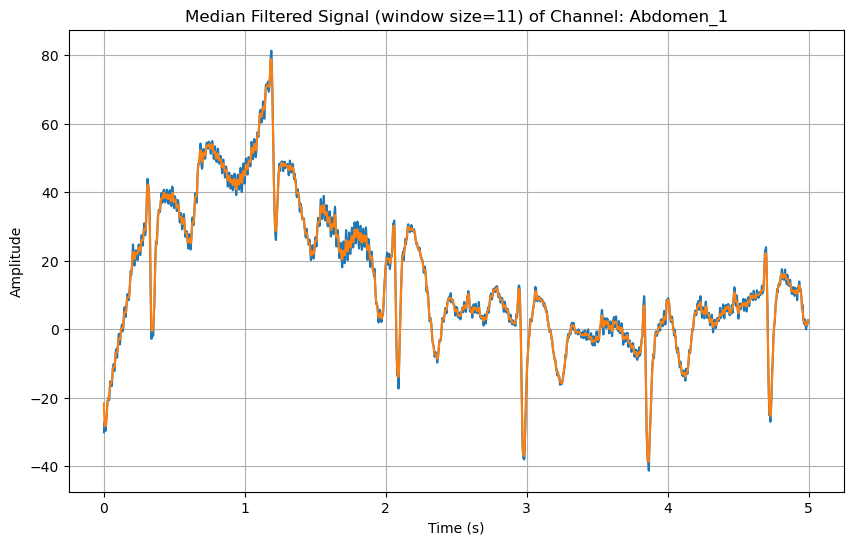

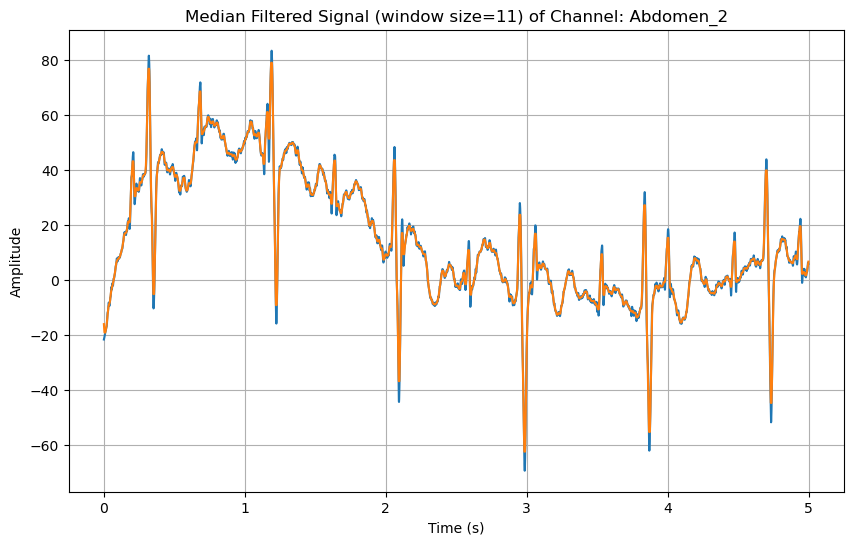

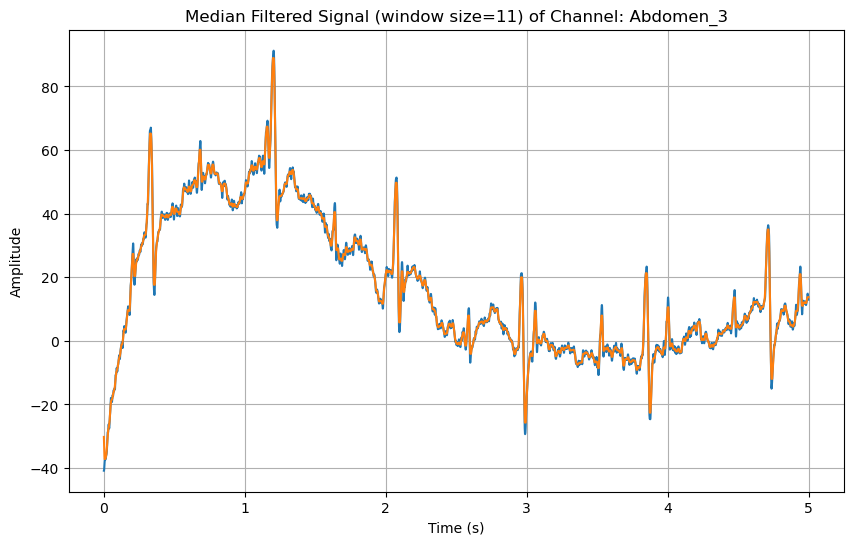

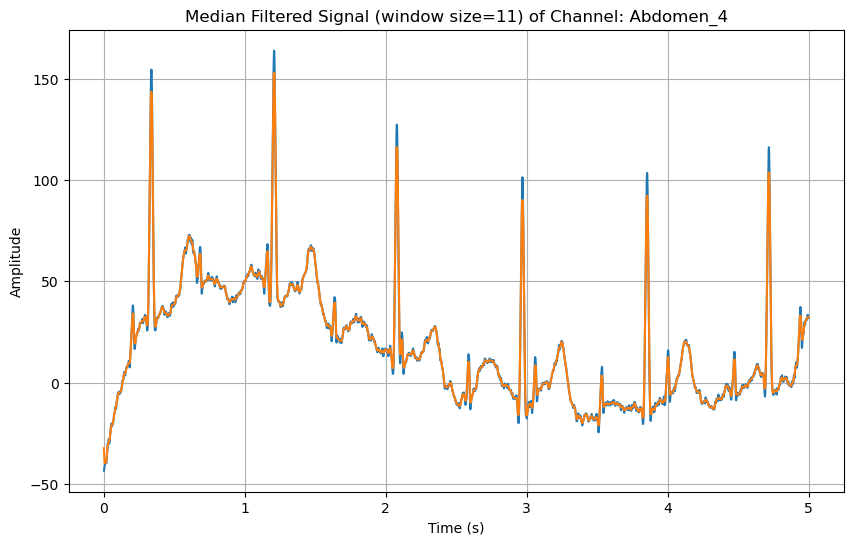

In [8]:
def median_filter_fir(data, window_size):
    # Apply a moving average filter using FIR approach
    kernel = np.ones(window_size) / window_size
    moving_avg = convolve(data, kernel, mode='same')
    
    # Apply non-linear operation to approximate median
    half_window = window_size // 2
    filtered_data = np.zeros_like(data)
    for i in range(len(data)):
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        window = moving_avg[start:end]
        filtered_data[i] = np.median(window)
    return filtered_data

window_size = 11

for i, label in enumerate(signal_labels):
    
    ecg_signal = f.readSignal(i)
    
    filtered_ecg_data = median_filter_fir(ecg_signal, window_size)
    
    plt.figure(figsize=(10, 6))
    plt.plot(time[:5000], ecg_signal[:5000], label='Original ECG Signal')
    plt.plot(time[:5000], filtered_ecg_data[:5000], label='Filtered Signal Median')
    plt.title('Median Filtered Signal (window size={}) of Channel: {}'.format(window_size, label))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
